# Decision tree model on Spark

In this notebook, we use a decision tree regression model (as implemented in Spark) to classify our pre-processed dataset. Specifically, we test the performance of our model with five different sets of features; then, we run a cross-validation on the one yielding the best results, to further optimize the obtained results.

Decision trees are one of the most used kind of models for classification and regression analysis. The idea behind decision trees induction is to learn a set of splits in an iterative fashion, aiming at each step to maximize the information gain. Each leaf node encodes a label, which is assigned to all records that reach it by traversing the sequence of splits.

In [1]:
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Input data parsing

In [2]:
inputPath = "/user/s291516/preprocessed/"
trainData = spark.read.format("csv").option("header", True).option("inferSchema", True).load(inputPath + "trainData/").cache()
testData = spark.read.format("csv").option("header", True).option("inferSchema", True).load(inputPath + "testData/").cache()

## Evaluators definition

In [3]:
rmseEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="NumBikes+1", metricName="rmse")
r2Evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="NumBikes+1", metricName="r2")
resultsDF = pd.DataFrame(columns=["Features", "Metric", "Value"])

## Label mapper definition

For prediction purposes, we are going to use the "diff" version of the features as produced in the data preprocessing notebook. The `LabelMapper` transformer will be used to translate back the "diff" prediction to a full prediction, obtained by summing the obtained prediction to the value of the `NumBikes` attribute.

In [4]:
class LabelMapper(Transformer):
    def _transform(self, inputDF):
        return inputDF.withColumn("prediction", F.col("prediction") + F.col("NumBikes"))

## Solution #1: only numerical features

In our first solution, we use only the numerical features exposed by our dataset (`NumBikesDiff-3`, `NumBikesDiff-2`, `NumBikesDiff-1`, `NumBikesDiff` and `NumBikes`) to predict the value of `NumBikesDiff+1`.

In [5]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=["NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes"], outputCol="features"),
    DecisionTreeRegressor(labelCol="NumBikesDiff+1", seed=42),
    LabelMapper()
])

model = pipeline.fit(trainData)

Once a decision tree model has been learned, we can have an idea of the relative importance of the different features that had been fed to the algorithm, which derives directly from the information gain that those were able to achieve during the training. In this case, we observe that the greatest contribution to the information gain is given by the `NumBikesDiff` attribute: this makes sense, since (as we observed in the baseline solution notebook) this already provides a "good enough" estimation of our target value. The `NumBikes` attribute also seems very relevant, while the other features provide a limited contribution.

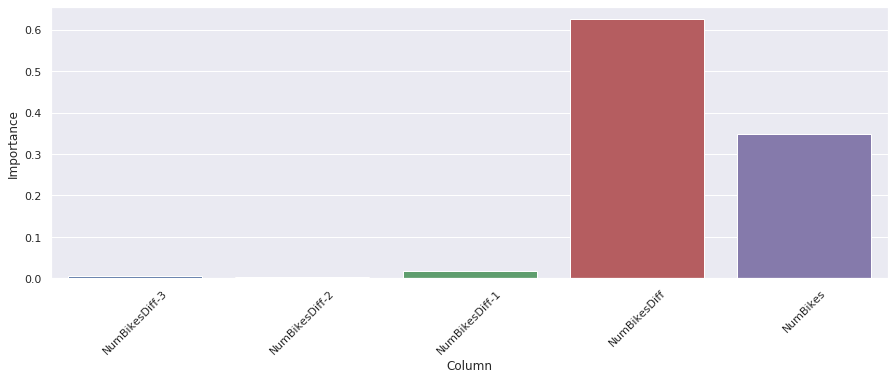

In [6]:
importanceDF = pd.DataFrame({
    "Column": model.stages[0].getInputCols(),
    "Importance": model.stages[1].featureImportances
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=importanceDF, x="Column", y="Importance", ax=ax)
ax.set_xticklabels(labels=importanceDF["Column"], rotation=45);

As far as the evaluation metrics are concerned, this solution outperforms the standard linear regression approach using the same set of features, presenting figures more similar to the ones of solution #4 of the previous notebook.

In [7]:
predictedTestData = model.transform(testData)

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "Only numerical", "Metric": "RMSE", "Value": rmse},
    {"Features": "Only numerical", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4342144966065773
R2: 0.9667519002737796


## Solution #2: simple categorical features

In the second solution, we enlarge the feature space by adding the values categorical features (the hour, the day of the week, and the zone of the station) into the model. Note that in this case we do not need to previously encode our features (for example, using one-hot encoding): decision trees indeed do not regress directly on any features; rather, they use them to design proper split values, and in this sense it does not matter if the feature is numerical or categorical.

In [8]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=[
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "Hour", "DayOfWeek", "Zone"
    ], outputCol="features"),
    DecisionTreeRegressor(labelCol="NumBikesDiff+1", seed=42),
    LabelMapper()
])

model = pipeline.fit(trainData)

In terms of feature importance, we observe how also in this case the greatest contribution is given by `NumBikesDiff` and `NumBikes`; a more limited contribution is given by `NumBikesDiff-1` and `Hour`.

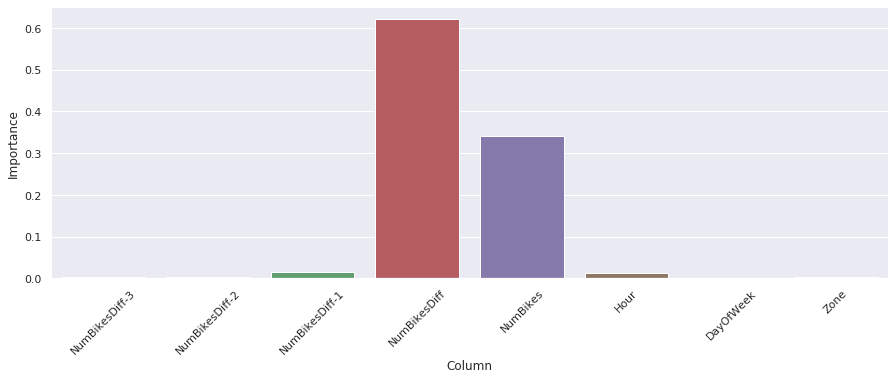

In [9]:
importanceDF = pd.DataFrame({
    "Column": model.stages[0].getInputCols(),
    "Importance": model.stages[1].featureImportances
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=importanceDF, x="Column", y="Importance", ax=ax)
ax.set_xticklabels(labels=importanceDF["Column"], rotation=45);

The resulting model performs slightly better than the previous one, as shown by the metrics below.

In [10]:
predictedTestData = model.transform(testData)

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "Categorical OH", "Metric": "RMSE", "Value": rmse},
    {"Features": "Categorical OH", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4341299215044652
R2: 0.9667558214146212


## Solution #3: disjoint, effect-encoded categorical features

In the third solution, we use the effect-encoded version of our categorical features, considering only the "disjoint" ones (i.e., we consider separately the effect of the hour, day of the week, and zone of the station).

In [11]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=[
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "AvgByHour", "AvgByWeekday", "AvgByZone"
    ], outputCol="features"),
    DecisionTreeRegressor(labelCol="NumBikesDiff+1", seed=42),
    LabelMapper()
])

model = pipeline.fit(trainData)

Again, we observe how the most important features in this model are `NumBikesDiff` and `NumBikes`; there is some contribution given by the aggregated metrics such as `AvgByHour` and `AvgByZone`.

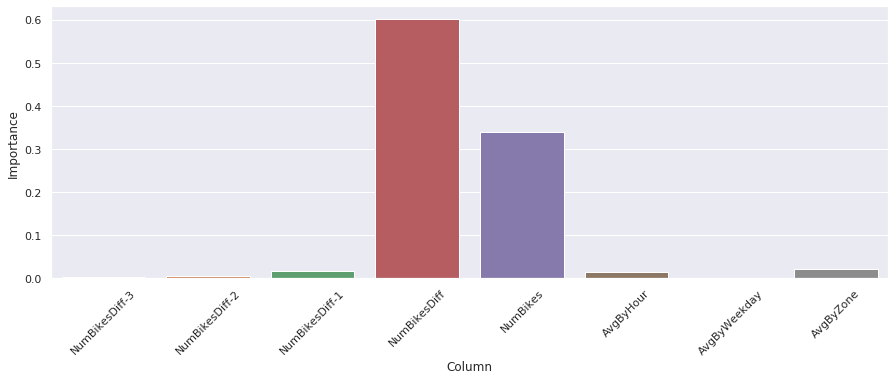

In [12]:
importanceDF = pd.DataFrame({
    "Column": model.stages[0].getInputCols(),
    "Importance": model.stages[1].featureImportances
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=importanceDF, x="Column", y="Importance", ax=ax)
ax.set_xticklabels(labels=importanceDF["Column"], rotation=45);

The resulting model is able to achieve a good performance improvement over the previous two, with reduced RMSE and increased R2.

In [13]:
predictedTestData = model.transform(testData)

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "Disjoint effect", "Metric": "RMSE", "Value": rmse},
    {"Features": "Disjoint effect", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4336286826834141
R2: 0.9667790555172834


## Solution #4: combined, effect-encoded categorical features

Here, we consider a solution in which we use all the available numerical features, plus the joint average computed considering all the categorical values at once.

In [14]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=["NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes", "AvgCombined"], outputCol="features"),
    DecisionTreeRegressor(labelCol="NumBikesDiff+1", seed=42),
    LabelMapper()
])

model = pipeline.fit(trainData)

In this model, a very significant contribution to the information gain is given by the aggregate value of `AvgCombined`, which ranks as the second feature by importance, after `NumBikesDiff` and before `NumBikes`.

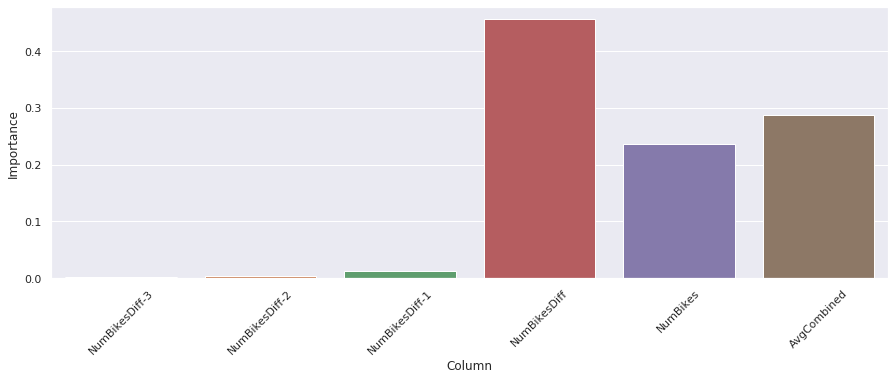

In [15]:
importanceDF = pd.DataFrame({
    "Column": model.stages[0].getInputCols(),
    "Importance": model.stages[1].featureImportances
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=importanceDF, x="Column", y="Importance", ax=ax)
ax.set_xticklabels(labels=importanceDF["Column"], rotation=45);

In terms of test metrics, this solution again improves quite a bit over the previous models, as shown below.

In [16]:
predictedTestData = model.transform(testData)

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "Combined effect", "Metric": "RMSE", "Value": rmse},
    {"Features": "Combined effect", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.430368452454437
R2: 0.9669299799186153


## Solution #5: putting all together

Finally, we test a solution in which all the aforementioned features are fed to the learning algorithm.

In [17]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=[
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "Hour", "DayOfWeek", "Zone",
        "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
    ], outputCol="features"),
    DecisionTreeRegressor(labelCol="NumBikesDiff+1", seed=42),
    LabelMapper()
])

model = pipeline.fit(trainData)

All in all, adding features over the ones used in solution #4 has a very limited effect; the most important features remain the `NumBikesDiff`, `AvgCombined` and `NumBikes`, whereas the categorical features, as well as the other aggregations, have nearly zero contribution.

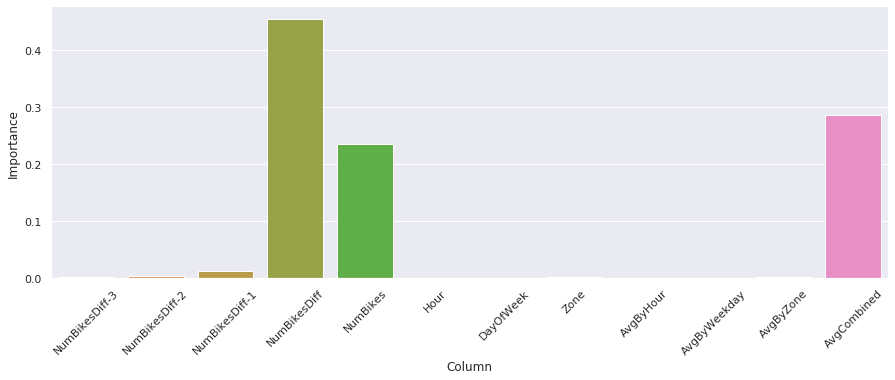

In [18]:
importanceDF = pd.DataFrame({
    "Column": model.stages[0].getInputCols(),
    "Importance": model.stages[1].featureImportances
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=importanceDF, x="Column", y="Importance", ax=ax)
ax.set_xticklabels(labels=importanceDF["Column"], rotation=45);

As a consequence, the improvement of reference metrics with respect to the previous case is very limited, and surely not enough to justify the usage (as-is) of a more complex model.

In [19]:
predictedTestData = model.transform(testData)

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "All", "Metric": "RMSE", "Value": rmse},
    {"Features": "All", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4303364081738479
R2: 0.9669314616251372


## Hyperparameter optimization

For solution #5, we run an optimization procedure to determine the best value for the parameters of the regression model, so to increase even further the performance of our model. To do so, we used the parameter grid defined in the cell below, in which we tested different values of all the parameters of Spark's decision tree model; then, we fitted a `Pipeline` object using a `CrossValidator` stage (the number of CV folds was set to its default value of 3).

In [20]:
dt = DecisionTreeRegressor()
grid = ParamGridBuilder() \
    .baseOn({dt.labelCol: "NumBikesDiff+1", dt.seed: 42}) \
    .addGrid(dt.maxDepth, [5, 10, 20]) \
    .addGrid(dt.minInstancesPerNode, [1, 10, 20]) \
    .addGrid(dt.minInfoGain, [0, 0.1, 0.2]) \
    .build()

In [21]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=[
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "Hour", "DayOfWeek", "Zone",
        "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
    ], outputCol="features"),
    CrossValidator(estimator=dt, estimatorParamMaps=grid, evaluator=RegressionEvaluator(predictionCol="prediction", labelCol="NumBikesDiff+1", metricName="rmse")),
    LabelMapper()
])

model = pipeline.fit(trainData)

The overall best model is characterized by the parameters below.

In [22]:
print("Best model params:")
print("\n".join([f"- {x[0].name}: {x[1]}" for x in model.stages[1].bestModel.extractParamMap().items()]))

Best model params:
- cacheNodeIds: False
- checkpointInterval: 10
- featuresCol: features
- impurity: variance
- labelCol: NumBikesDiff+1
- maxBins: 32
- maxDepth: 10
- maxMemoryInMB: 256
- minInfoGain: 0.0
- minInstancesPerNode: 20
- predictionCol: prediction
- seed: 42


With respect to the unoptimized case, observing the feature importance graph we observe how, while the most important attributes remain `NumBikesDiff`, `AvgCombined` and `NumBikes`, now more features contribute to the information gain. This is an indication that probably our previous model was "too simple" and not able to fit well our data; thus, after the parameter optimization, we can expect to have a better representation of our data.

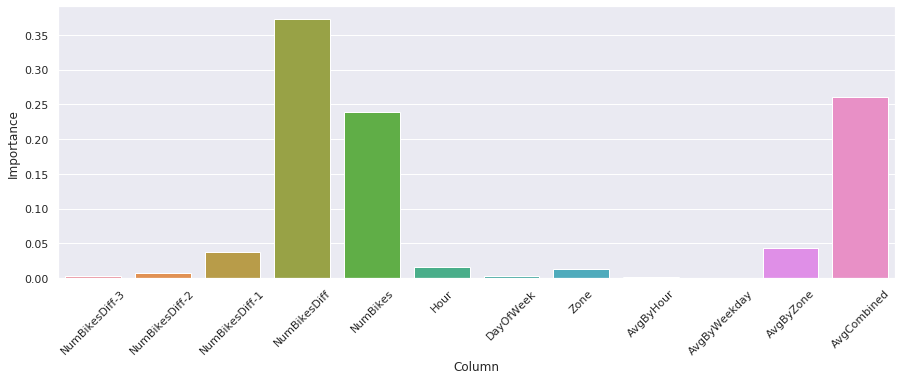

In [23]:
importanceDF = pd.DataFrame({
    "Column": model.stages[0].getInputCols(),
    "Importance": model.stages[1].bestModel.featureImportances
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=importanceDF, x="Column", y="Importance", ax=ax)
ax.set_xticklabels(labels=importanceDF["Column"], rotation=45);

As expected, when we apply the optimized model on our test data, we observe a significant improvement of the evaluation metrics, greater than any difference we were able to observe by any enrichment of the feature space performed above.

In [24]:
predictedTestData = model.transform(testData)

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "All (CV)", "Metric": "RMSE", "Value": rmse},
    {"Features": "All (CV)", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4185025253889312
R2: 0.9674763829099808


## Comparison of the results

The two graphs below summarize the evolution of the RMSE and R2 metrics for the different sets of features tested.

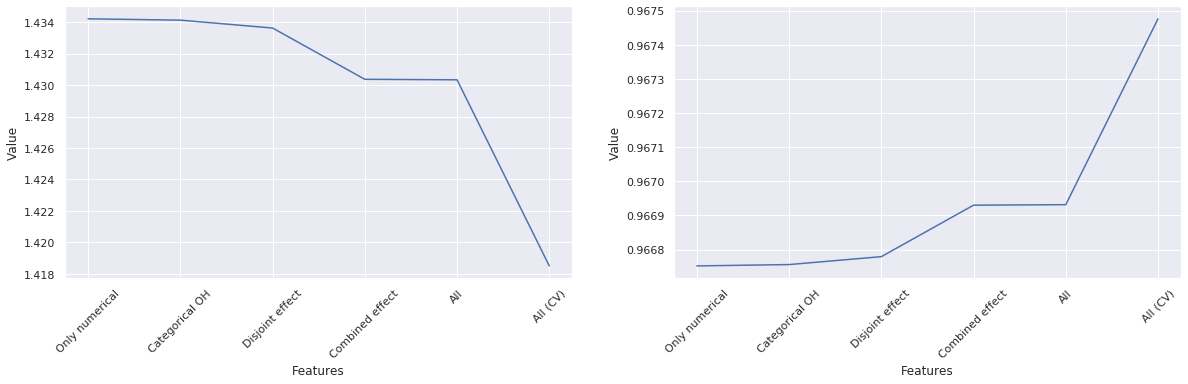

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.lineplot(data=resultsDF[resultsDF["Metric"] == "RMSE"], x="Features", y="Value", ax=ax[0])
sns.lineplot(data=resultsDF[resultsDF["Metric"] == "R2"], x="Features", y="Value", ax=ax[1])
ax[0].set_xticklabels(labels=resultsDF[resultsDF["Metric"] == "RMSE"]["Features"], rotation=45)
ax[1].set_xticklabels(labels=resultsDF[resultsDF["Metric"] == "R2"]["Features"], rotation=45);